## Initialization

In [629]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Grid size
NX = 100
NY = 150

omega = 1

weights = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
#weights = np.array([5/9, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18])
c = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1]])

######
# Initialise arrays

scenario = 1;

if(scenario == 0):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    dfield[NX//2, NY//2] *= 2

if(scenario == 1):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    dfield[:, :] = 1 + 0.5 * np.sin(2*np.pi*np.arange(0,NY)/NX)

if(scenario == 2):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    vfield[0, :, :] = 0.01 * np.sin(2*np.pi*np.arange(0,NY)/NX)

ffield = np.einsum("i,jk -> ijk", weights, np.ones((NX, NY)))  # Format: (channel, x, y)
######

## Show density before simulation

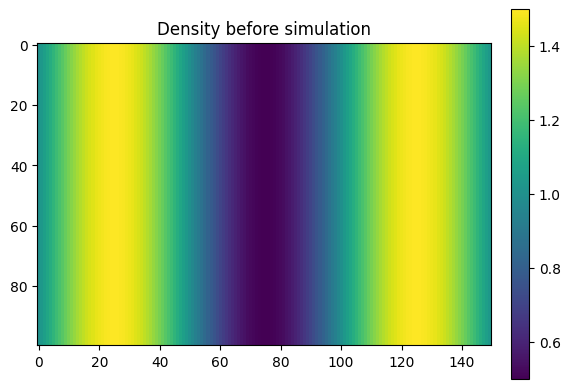

In [630]:
fig, ax = plt.subplots()
im = ax.imshow(dfield)
plt.title("Density before simulation")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

In [631]:
def calc_equi(dfield, vfield):
    # Caluculate the equilibrium distribution function
    f_equi = np.zeros_like(ffield)
    v_abs = np.einsum("ijk -> jk", vfield)  # Maybe negative but will be squared anyway
    for channel in range(9):
        scal = np.einsum("i, ijk -> jk", c[channel], vfield)
        sum = np.ones_like(scal) + 3 * scal + 9/2 * scal * scal - 3/2 * v_abs * v_abs
        f_equi[channel, :, :] = weights[channel] * dfield * sum
    return f_equi

def streaming(dfield, ffield, boundary = "periodic"):
    f_equi = calc_equi(dfield, vfield)

    ffield += omega * (f_equi - ffield)

    for channel in range(9):
        ffield[channel] = np.roll(ffield[channel], shift=c[channel], axis=(0,1))


    return ffield

In [632]:
def recalculate(ffield, dfield, vfield):

    dfield = np.einsum("ijk -> jk", ffield)  # density field
    vfield_noscale = np.einsum("ijk, il -> ljk", ffield, c)  # velocity field
    vfield = np.einsum("ijk, jk -> ijk", vfield_noscale, np.reciprocal(dfield))  # divide by rho to get averange velocity

    return ffield, dfield, vfield

dfield_init = dfield

Simulating: 100%|██████████| 3000/3000 [00:08<00:00, 372.22it/s]


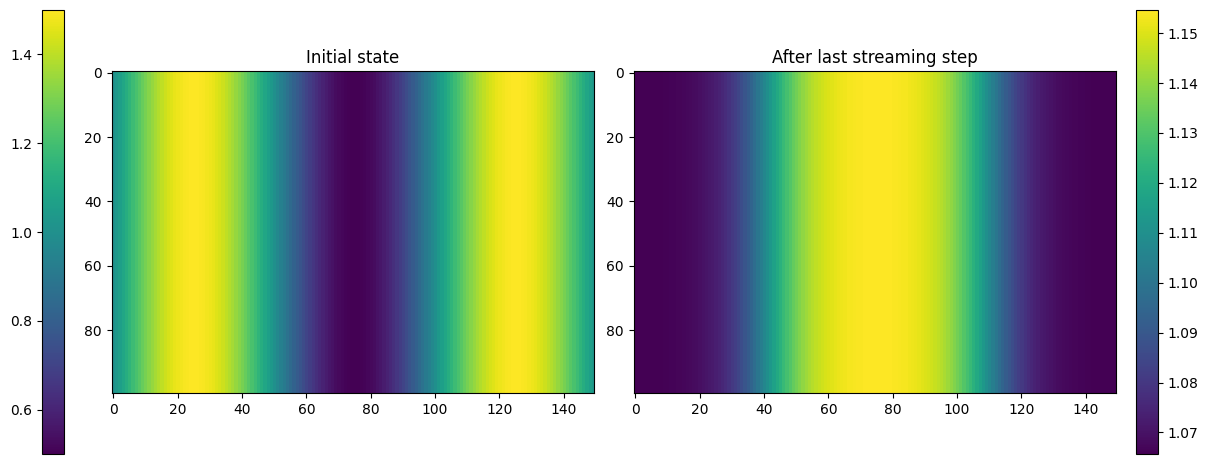

[[ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]
 [ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]
 [ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]
 ...
 [ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]
 [ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]
 [ 0.06568264  0.03429209  0.00303498 ... -0.02796497  0.00303498
   0.03429209]]
-2.563218970408343e-09


In [633]:
fig, axs = plt.subplots(1, 2, layout='constrained')
fig.set_size_inches(12, 12)

im_init = axs[0].imshow(dfield_init)
axs[0].set_title("Initial state")
plt.colorbar(im_init,fraction=0.046, pad=0.04, location="left")

amp = []

for step in tqdm(range(3000), "Simulating"):

    ffield = streaming(dfield, ffield)
    ffield, dfield, vfield = recalculate(ffield, dfield, vfield)

    amp.append(np.max(np.absolute(vfield[1,0,:]) /0.1))

im_end = axs[1].imshow(dfield)
axs[1].set_title("After last streaming step")
plt.colorbar(im_end,fraction=0.046, pad=0.04)

plt.show()

print(dfield - dfield_init)
print(np.einsum("ij ->", (dfield - dfield_init)))

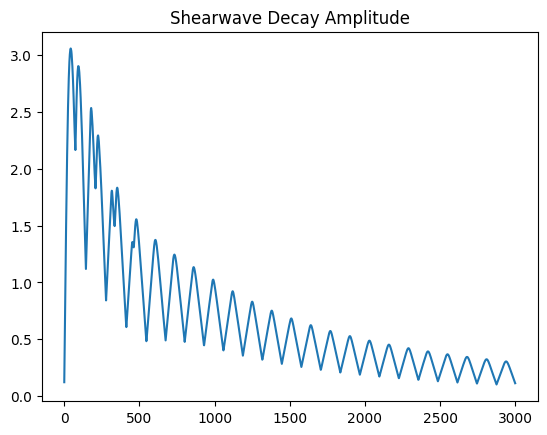

In [634]:
plt.plot(np.arange(len(amp)), amp)
plt.title("Shearwave Decay Amplitude")
plt.savefig("decay_plot.png")
plt.show()

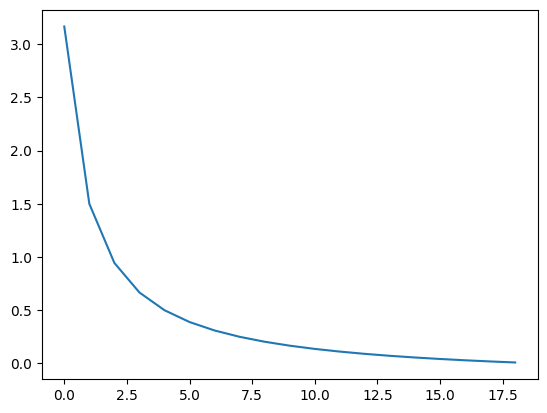

In [635]:
# Calculate analytic prediction of kinematic viscosity.
omega_values = [i / 100 for i in range(10, 200, 10)]
vis_ana = [1/3 * (1/omega - 1/2) for omega in omega_values]
plt.plot(vis_ana)